In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [4]:
DATA = r"C:\Users\Hipor\projects\practical-statistics-for-data-scientists\data\\"
WEB_PAGE_DATA_CSV = DATA + 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA + 'four_sessions.csv'
CLICK_RATE_CSV = DATA + 'click_rates.csv'
IMANISHI_CSV = DATA + 'imanishi_data.csv'

In [8]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


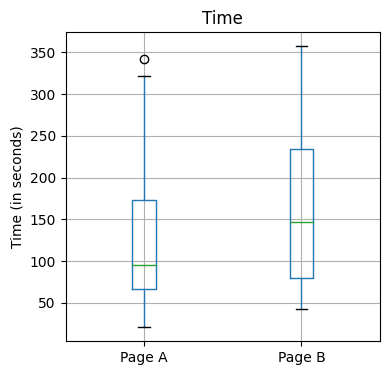

In [13]:
ax = session_times.boxplot(by='Page', column='Time', figsize=(4,4))

ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


In [47]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


In [31]:
def perm_fun(x, nA, nB):
    #функция которая отбирает рандомные числа из масива и 
    #возвращает среднии в соответствии с размерами выборок
    n = nA +nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()
#находим размер выборок по группам
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

35.09523809523809


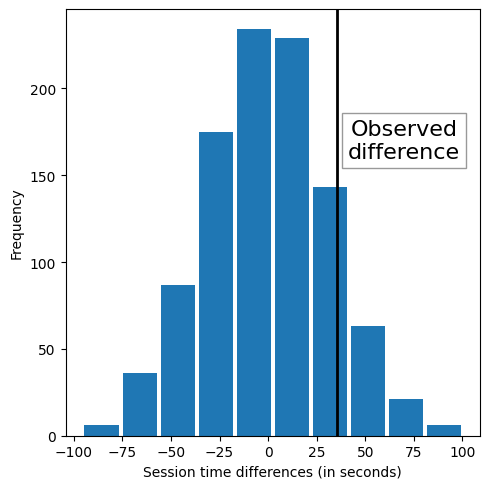

In [50]:
#сделаем распределение данных отклонений после пермутации
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs,  bins=10, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(70,170, 'Observed\ndifference', bbox={"facecolor":'white', "alpha":0.4},
        verticalalignment='center', horizontalalignment='center', fontsize=16)
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()